<a href="https://colab.research.google.com/github/GadirajuSanjayvarma/EVA4/blob/master/S12/Task1/S12_file1__Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
!git clone https://github.com/GadirajuSanjayvarma/EVA4_LIBRARY.git

Cloning into 'EVA4_LIBRARY'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 112 (delta 51), reused 88 (delta 43), pack-reused 0
Receiving objects: 100% (112/112), 31.94 KiB | 883.00 KiB/s, done.
Resolving deltas: 100% (51/51), done.


In [0]:
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

# Dataset and Creating Train/Test Split

Get the imagenet dataset

In [0]:
! git clone https://github.com/seshuad/IMagenet

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 31.46 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.


Create 70/30 split after combining train/test
We have separately calculated the mean/std or we can use 0.5s

In [0]:
import random
from tqdm.notebook import tqdm, trange
path = 'IMagenet/tiny-imagenet-200/'
class_ids = [line.strip() for line in open( path + 'wnids.txt', 'r')]
id_dict = {x:i for i, x in enumerate(class_ids)}
all_classes = {line.split('\t')[0] : line.split('\t')[1].strip() for line in open( path + 'words.txt', 'r')}
class_names = [all_classes[x] for x in class_ids]

images = []
labels = []

# train data
for value, key in tqdm(enumerate(class_ids)):
  images += [f'{path}train/{key}/images/{key}_{i}.JPEG' for i in range(500)]
  labels += [value for i in range(500)]

# validation data
for line in tqdm(open( path + 'val/val_annotations.txt')):
    img_name, class_id = line.split('\t')[:2]
    images.append(f'{path}val/images/{img_name}')
    labels.append(id_dict[class_id])

dataset = list(zip(images, labels))
random.shuffle(dataset)
trainlen = int(len(dataset)*0.7)
print(len(dataset), trainlen)


110000 77000


### Create DataSet

In [0]:
import torch
from skimage import io
import numpy as np
from torch.utils.data import Dataset

class TinyImagenetDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data, transform=None):
        """
        Args:
            data (string): zipped images and labels.
        """
        self.transform = transform
        self.images, self.labels = zip(*data)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = io.imread(self.images[idx], as_gray=False, pilmode="RGB")
        # We don't want one hot encoding here
        # https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.nll_loss
        #label = np.array([0]*200)
        #label[self.labels[idx]] = 1

        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx] #label

## Data collection and Prep

Get the Albumentations library

In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-agfbef_n
All libraries are successfully installed!


## Data Transformations

We first start with defining our data transformations. 

* padding of 4 pixels on each side (we are padding by mean)
* RandomCrop 32, 32 (after padding of 4)
* FlipLR
* Followed by CutOut(8, 8)


In [0]:
import cv2
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A
from torchvision import transforms
# The values here are elsewhere calculated
channel_means = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                      A.PadIfNeeded(min_height=80, min_width=80, border_mode=cv2.BORDER_CONSTANT, value=np.array(channel_means)*255),
                                      A.RandomCrop(64,64, always_apply=True),
                                      A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=4, max_h_size=16, max_w_size=16) # fillvalue is 0 after normalizing as mean is 0
                                    ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



In [0]:
train = TinyImagenetDataset(dataset[:trainlen], transform=train_transforms)
test = TinyImagenetDataset(dataset[trainlen:], transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders
batch_size=256

dataloader = eva4dataloaders.DataLoader(batch_size=batch_size, shuffle=True)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([256, 3, 64, 64])
torch.Size([256])
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)
(3, 64, 64)


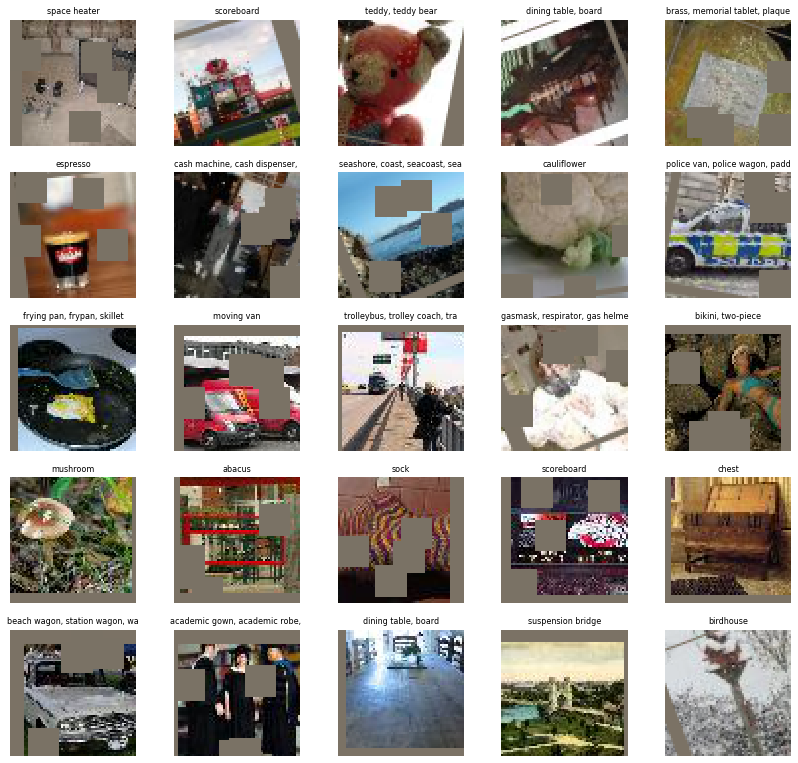

In [0]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax = plt.subplot(r, c, idx+1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize': 8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation='none')
plt.show()

# Model Creation

We will be calling ResNet18 model here.

In [0]:
import eva4models1
import torch
model =eva4models1.ResNet18(num_classes=200)
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

# LR Finder
train for 10 epochs by exponentially moving LR from 1e-5 to 2

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


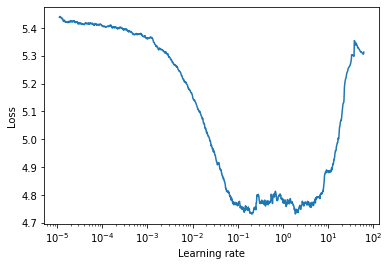

In [0]:
# LR finder
import torch.nn as nn
import torch.nn.functional as F
from eva4LRFinder import LRFinder
import torch.optim as optim
L1lambda = 1e-4
L2lambda = 1e-3
criterion = F.nll_loss
optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=L2lambda) #optim.Adam(model.parameters(), lr=1e-5, weight_decay=L2lambda) # 
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=len(train_loader)*5)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(lr[loss.index(min(loss))])


0.204940554523735


In [0]:
max_lr = lr[loss.index(min(loss))]
max_lr

0.204940554523735

This test indicates the mx lr to use as 0.0073 and start of reducing is 100 times less than that. We tried that and got 88% only in 24 epochs. We realize that this is a very steep valley so let us pick a more wide region. We pick the next region around 0.1 with minlr .0001

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions using One Cycle Policy Scheduler. We use final_div_factor = 1 so as there is no annihilation.

In [0]:
import torch.optim as optim
import torch.nn as nn
#from torch.optim.lr_scheduler import StepLR
#optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.95, weight_decay=1e-4)
L1lambda = 0
L2lambda = 1e-4
EPOCHS = 50
max_lr=1
optimizer = optim.SGD(model.parameters(), lr=max_lr/10, momentum=0.9, nesterov=True, weight_decay=L2lambda)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader), div_factor=5, pct_start=0.2, epochs=EPOCHS)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train)/batch_size)+1, epochs=EPOCHS,  pct_start=5/24, div_factor=600, final_div_factor=1 )
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train_loader))+1, epochs=EPOCHS,  pct_start=0.2, div_factor=10, final_div_factor=100 )
print("Initial LR- ",scheduler.get_lr())
print("Total steps - ", scheduler.total_steps)
print("No.of steps to increase LR -", scheduler.step_size_up)
print("No.of steps to reduce LR - ", scheduler.step_size_down)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True,L1lambda)

Initial LR-  [0.09999999999999998]
Total steps -  15100
No.of steps to increase LR - 3019.0
No.of steps to reduce LR -  12080.0



Validation loss decreased (100000.000000 --> 4.293012).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0184, Accuracy: 5.36%; Test set: Average loss: 4.2930, Accuracy: 9.31%
Learning Rate = 0.121895



Validation loss decreased (4.293012 --> 3.809017).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0161, Accuracy: 11.91%; Test set: Average loss: 3.8090, Accuracy: 16.32%
Learning Rate = 0.185448



Validation loss decreased (3.809017 --> 3.582101).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0144, Accuracy: 18.36%; Test set: Average loss: 3.5821, Accuracy: 19.47%
Learning Rate = 0.284475



Validation loss decreased (3.582101 --> 3.559732).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0132, Accuracy: 23.57%; Test set: Average loss: 3.5597, Accuracy: 22.71%
Learning Rate = 0.409340



Epoch: 5, Train set: Average loss: 0.0122, Accuracy: 27.78%; Test set: Average loss: 3.8084, Accuracy: 21.27%
Learning Rate = 0.547893



Validation loss decreased (3.559732 --> 3.180488).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0115, Accuracy: 31.17%; Test set: Average loss: 3.1805, Accuracy: 29.99%
Learning Rate = 0.686651



Validation loss decreased (3.180488 --> 3.101685).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0110, Accuracy: 33.84%; Test set: Average loss: 3.1017, Accuracy: 30.26%
Learning Rate = 0.812111



Epoch: 8, Train set: Average loss: 0.0105, Accuracy: 36.18%; Test set: Average loss: 3.2873, Accuracy: 28.78%
Learning Rate = 0.912066



Epoch: 9, Train set: Average loss: 0.0101, Accuracy: 38.21%; Test set: Average loss: 3.8895, Accuracy: 23.21%
Learning Rate = 0.976788



Validation loss decreased (3.101685 --> 2.893630).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0097, Accuracy: 40.02%; Test set: Average loss: 2.8936, Accuracy: 34.85%
Learning Rate = 0.999980



Epoch: 11, Train set: Average loss: 0.0095, Accuracy: 41.51%; Test set: Average loss: 2.9675, Accuracy: 34.46%
Learning Rate = 0.998560



Epoch: 12, Train set: Average loss: 0.0092, Accuracy: 42.98%; Test set: Average loss: 3.1593, Accuracy: 33.62%
Learning Rate = 0.994072



Validation loss decreased (2.893630 --> 2.732944).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0090, Accuracy: 43.92%; Test set: Average loss: 2.7329, Accuracy: 37.52%
Learning Rate = 0.986560



Epoch: 14, Train set: Average loss: 0.0088, Accuracy: 44.98%; Test set: Average loss: 3.5893, Accuracy: 28.28%
Learning Rate = 0.976072



Epoch: 15, Train set: Average loss: 0.0086, Accuracy: 45.76%; Test set: Average loss: 3.2178, Accuracy: 35.31%
Learning Rate = 0.962671



Epoch: 16, Train set: Average loss: 0.0085, Accuracy: 46.45%; Test set: Average loss: 3.0385, Accuracy: 36.67%
Learning Rate = 0.946439



Epoch: 17, Train set: Average loss: 0.0083, Accuracy: 47.41%; Test set: Average loss: 2.7602, Accuracy: 38.86%
Learning Rate = 0.927476



Epoch: 18, Train set: Average loss: 0.0082, Accuracy: 48.13%; Test set: Average loss: 2.8134, Accuracy: 38.48%
Learning Rate = 0.905898



Epoch: 19, Train set: Average loss: 0.0081, Accuracy: 48.74%; Test set: Average loss: 2.8000, Accuracy: 39.09%
Learning Rate = 0.881837



Validation loss decreased (2.732944 --> 2.688999).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0080, Accuracy: 49.58%; Test set: Average loss: 2.6890, Accuracy: 39.66%
Learning Rate = 0.855441



Validation loss decreased (2.688999 --> 2.590641).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0078, Accuracy: 50.11%; Test set: Average loss: 2.5906, Accuracy: 41.26%
Learning Rate = 0.826870



Validation loss decreased (2.590641 --> 2.548058).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0077, Accuracy: 50.65%; Test set: Average loss: 2.5481, Accuracy: 42.42%
Learning Rate = 0.796301



Epoch: 23, Train set: Average loss: 0.0076, Accuracy: 51.52%; Test set: Average loss: 2.6474, Accuracy: 41.58%
Learning Rate = 0.763920



Epoch: 24, Train set: Average loss: 0.0075, Accuracy: 51.77%; Test set: Average loss: 2.6497, Accuracy: 41.06%
Learning Rate = 0.729926


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f114051c710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f114051c710>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f114051c710>>
    self._shutdown_workers()
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f114051c710>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_wo

Validation loss decreased (2.548058 --> 2.533282).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0074, Accuracy: 52.38%; Test set: Average loss: 2.5333, Accuracy: 43.94%
Learning Rate = 0.694527


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f114051c710>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f114051c710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    assert self._parent_pid == 


Validation loss decreased (2.533282 --> 2.446355).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0073, Accuracy: 53.14%; Test set: Average loss: 2.4464, Accuracy: 43.63%
Learning Rate = 0.657939



Epoch: 27, Train set: Average loss: 0.0072, Accuracy: 53.78%; Test set: Average loss: 2.5159, Accuracy: 45.18%
Learning Rate = 0.620387



Epoch: 28, Train set: Average loss: 0.0070, Accuracy: 54.39%; Test set: Average loss: 2.4637, Accuracy: 45.27%
Learning Rate = 0.582101



Epoch: 29, Train set: Average loss: 0.0069, Accuracy: 54.91%; Test set: Average loss: 2.7082, Accuracy: 41.59%
Learning Rate = 0.543315



Epoch: 30, Train set: Average loss: 0.0068, Accuracy: 55.76%; Test set: Average loss: 2.5700, Accuracy: 42.50%
Learning Rate = 0.504267



Validation loss decreased (2.446355 --> 2.353021).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0066, Accuracy: 56.65%; Test set: Average loss: 2.3530, Accuracy: 46.87%
Learning Rate = 0.465196



Epoch: 32, Train set: Average loss: 0.0065, Accuracy: 57.20%; Test set: Average loss: 2.4416, Accuracy: 45.81%
Learning Rate = 0.426341



Epoch: 33, Train set: Average loss: 0.0063, Accuracy: 58.29%; Test set: Average loss: 2.5969, Accuracy: 44.36%
Learning Rate = 0.387940



Validation loss decreased (2.353021 --> 2.344783).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0062, Accuracy: 59.43%; Test set: Average loss: 2.3448, Accuracy: 47.94%
Learning Rate = 0.350229



Epoch: 35, Train set: Average loss: 0.0059, Accuracy: 60.65%; Test set: Average loss: 2.3622, Accuracy: 47.09%
Learning Rate = 0.313438



Epoch: 36, Train set: Average loss: 0.0057, Accuracy: 61.90%; Test set: Average loss: 2.4538, Accuracy: 47.41%
Learning Rate = 0.277792



Validation loss decreased (2.344783 --> 2.257540).  Saving model ...
Epoch: 37, Train set: Average loss: 0.0055, Accuracy: 63.37%; Test set: Average loss: 2.2575, Accuracy: 50.54%
Learning Rate = 0.243511



Epoch: 38, Train set: Average loss: 0.0052, Accuracy: 65.11%; Test set: Average loss: 2.3877, Accuracy: 50.32%
Learning Rate = 0.210803



Validation loss decreased (2.257540 --> 2.218224).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0049, Accuracy: 66.58%; Test set: Average loss: 2.2182, Accuracy: 51.47%
Learning Rate = 0.179870



Validation loss decreased (2.218224 --> 2.085407).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0046, Accuracy: 68.82%; Test set: Average loss: 2.0854, Accuracy: 54.76%
Learning Rate = 0.150901



Epoch: 41, Train set: Average loss: 0.0041, Accuracy: 71.40%; Test set: Average loss: 2.2148, Accuracy: 54.21%
Learning Rate = 0.124072



Epoch: 42, Train set: Average loss: 0.0037, Accuracy: 73.81%; Test set: Average loss: 2.1217, Accuracy: 55.51%
Learning Rate = 0.099549



Epoch: 43, Train set: Average loss: 0.0033, Accuracy: 77.05%; Test set: Average loss: 2.1113, Accuracy: 56.65%
Learning Rate = 0.077482



Validation loss decreased (2.085407 --> 2.050089).  Saving model ...
Epoch: 44, Train set: Average loss: 0.0027, Accuracy: 80.54%; Test set: Average loss: 2.0501, Accuracy: 57.71%
Learning Rate = 0.058006



Validation loss decreased (2.050089 --> 2.021673).  Saving model ...
Epoch: 45, Train set: Average loss: 0.0022, Accuracy: 84.29%; Test set: Average loss: 2.0217, Accuracy: 59.17%
Learning Rate = 0.041240



Validation loss decreased (2.021673 --> 1.954577).  Saving model ...
Epoch: 46, Train set: Average loss: 0.0018, Accuracy: 87.20%; Test set: Average loss: 1.9546, Accuracy: 60.43%
Learning Rate = 0.027286



Validation loss decreased (1.954577 --> 1.940661).  Saving model ...
Epoch: 47, Train set: Average loss: 0.0015, Accuracy: 89.98%; Test set: Average loss: 1.9407, Accuracy: 61.08%
Learning Rate = 0.016231



Validation loss decreased (1.940661 --> 1.913457).  Saving model ...
Epoch: 48, Train set: Average loss: 0.0012, Accuracy: 91.90%; Test set: Average loss: 1.9135, Accuracy: 61.66%
Learning Rate = 0.008142



Validation loss decreased (1.913457 --> 1.896779).  Saving model ...
Epoch: 49, Train set: Average loss: 0.0011, Accuracy: 93.15%; Test set: Average loss: 1.8968, Accuracy: 61.84%
Learning Rate = 0.003068



Epoch: 50, Train set: Average loss: 0.0010, Accuracy: 93.73%; Test set: Average loss: 1.9010, Accuracy: 61.94%
Learning Rate = 0.001041



In [0]:
for idx, group in enumerate(scheduler.optimizer.param_groups):
  print(group['initial_lr'], group['max_lr'], group['min_lr'])
  

0.1 1 0.001


In [0]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.9372727272727273
0.6193939393939394


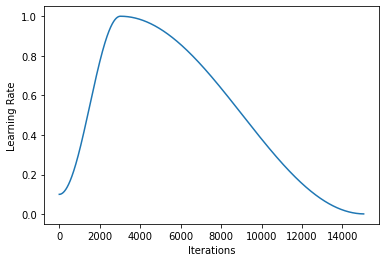

In [0]:
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.plot(model.stats().batch_lr)
plt.show()